# **Importing the Data**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from joblib import Parallel, delayed
import os
import multiprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as skm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data1 = pd.read_csv("r001early.csv")
data2 = pd.read_csv("r001late.csv")
ozone_data = pd.concat([data1,data2])
ozone_data = ozone_data.reset_index()

'\ndata1 = pd.read_csv("r001early.csv")\ndata2 = pd.read_csv("r001late.csv")\nozone_data = pd.concat([data1,data2])\nozone_data = ozone_data.reset_index()\n'

# **Preprocessing**

Select the data where that will be used for the model which includes the hourly data from 2008 to 2019. The unnecessary columns are moved to only keep the columns with concentration values and the date and time at which each concentration is measured.

## Making Concentration values NA for validity = 0 and validity = 1

In [5]:
ozone_data.head()

,index,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog
0,0,BE/SPO-BETR001_00007_100,7,1997-01-01T00:00:00,1997-01-01T01:00:00,-999.0,ug.m-3,hour,-1,1,2016-08-17T07:51:15.530,0.0,NaN
1,1,BE/SPO-BETR001_00007_100,7,1997-01-01T01:00:00,1997-01-01T02:00:00,-999.0,ug.m-3,hour,-1,1,2016-08-17T07:51:15.530,0.0,NaN
2,2,BE/SPO-BETR001_00007_100,7,1997-01-01T02:00:00,1997-01-01T03:00:00,-999.0,ug.m-3,hour,-1,1,2016-08-17T07:51:15.530,0.0,NaN
3,3,BE/SPO-BETR001_00007_100,7,1997-01-01T03:00:00,1997-01-01T04:00:00,-999.0,ug.m-3,hour,-1,1,2016-08-17T07:51:15.530,0.0,NaN
4,4,BE/SPO-BETR001_00007_100,7,1997-01-01T04:00:00,1997-01-01T05:00:00,-999.0,ug.m-3,hour,-1,1,2016-08-17T07:51:15.530,0.0,NaN


In [6]:
ozone_data['Validity'].unique()

array([-1,  1,  0])

In [7]:
#Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity -1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETR001_00007_100          7  1997-01-01T00:00:00   
1      1  BE/SPO-BETR001_00007_100          7  1997-01-01T01:00:00   
2      2  BE/SPO-BETR001_00007_100          7  1997-01-01T02:00:00   
3      3  BE/SPO-BETR001_00007_100          7  1997-01-01T03:00:00   
4      4  BE/SPO-BETR001_00007_100          7  1997-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1997-01-01T01:00:00 -999.0  ug.m-3    hour        -1             1   
1  1997-01-01T02:00:00 -999.0  ug.m-3    hour        -1             1   
2  1997-01-01T03:00:00 -999.0  ug.m-3    hour        -1             1   
3  1997-01-01T04:00:00 -999.0  ug.m-3    hour        -1             1   
4  1997-01-01T05:00:00 -999.0  ug.m-3    hour        -1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530          0.0              Na

In [8]:
# Check rows with Validity = 0 or Validity = -1 and set Value to NaN
ozone_data.loc[(ozone_data['Validity'] == 0) | (ozone_data['Validity'] == -1), 'Value'] = None

In [9]:
#Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity -1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETR001_00007_100          7  1997-01-01T00:00:00   
1      1  BE/SPO-BETR001_00007_100          7  1997-01-01T01:00:00   
2      2  BE/SPO-BETR001_00007_100          7  1997-01-01T02:00:00   
3      3  BE/SPO-BETR001_00007_100          7  1997-01-01T03:00:00   
4      4  BE/SPO-BETR001_00007_100          7  1997-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1997-01-01T01:00:00    NaN  ug.m-3    hour        -1             1   
1  1997-01-01T02:00:00    NaN  ug.m-3    hour        -1             1   
2  1997-01-01T03:00:00    NaN  ug.m-3    hour        -1             1   
3  1997-01-01T04:00:00    NaN  ug.m-3    hour        -1             1   
4  1997-01-01T05:00:00    NaN  ug.m-3    hour        -1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530          0.0              Na

In [10]:
columns_remove = ['Samplingpoint','Pollutant','End','Unit','AggType','Validity','Verification','ResultTime','DataCapture','FkObservationLog','index']
ozone_data = ozone_data.drop(columns=columns_remove)

# Sampling Point: BE/SPO-BETN073_00007_100
# Pollutant: 7 (O_3)
# End: Start with 1 hour added
# Unit: ug.m-3
# Aggregation Type: hour
# Validaity/Verification: 1 & 1
# Result Time: Time and Date when data is added to the whole data file
# Data Capture: 0
# FkObservation log: Do not know meaning, values from NaN to 0fa5da4d-ae92-4bb7-bcd4-07fb6b962ae4

ozone_data['Start'] = pd.to_datetime(ozone_data['Start'])
data = ozone_data[(ozone_data['Start'].dt.year >= 2007) & (ozone_data['Start'].dt.year <= 2019)]
data = data.reset_index()
data = data.drop(columns=['index'])
data.rename(columns={'Value': 'Concentration'}, inplace=True)

Thus the following dataframe only

In [11]:
data.head()

,Start,Concentration
0,2007-01-01 00:00:00,55.0
1,2007-01-01 01:00:00,68.0
2,2007-01-01 02:00:00,67.0
3,2007-01-01 03:00:00,64.0
4,2007-01-01 04:00:00,69.0


The data is checked to make sure there are no duplicates.

In [12]:
duplicates = data.duplicated(subset=['Start'])

# Print or further process the duplicate values
print("Duplicate values in the column Start:", duplicates.any())

Duplicate values in the column Start: False


## Adding new variables

From the Start column, we extracr the year, month, day and time.

In [13]:
# Extract year, month, day, and time into separate columns
data['Year'] = data['Start'].dt.year
data['Month'] = data['Start'].dt.month
data['Day'] = data['Start'].dt.day
data['Time'] = data['Start'].dt.time

# Display the transformed DataFrame
print(data.head())

                Start  Concentration  Year  Month  Day      Time
0 2007-01-01 00:00:00           55.0  2007      1    1  00:00:00
1 2007-01-01 01:00:00           68.0  2007      1    1  01:00:00
2 2007-01-01 02:00:00           67.0  2007      1    1  02:00:00
3 2007-01-01 03:00:00           64.0  2007      1    1  03:00:00
4 2007-01-01 04:00:00           69.0  2007      1    1  04:00:00


From the Start column the day of the week can be extracted, which can also be used to determine if that measurement was taken during the weekend.

In [14]:
# Extract day of the week
data['DayOfWeek'] = (data['Start'].dt.weekday + 1) % 7

# Create a new column indicating whether the day is a weekend or not
data['Weekend'] = (data['Start'].dt.dayofweek // 5).astype(int)

In [15]:
data.head()

,Start,Concentration,Year,Month,Day,Time,DayOfWeek,Weekend
0,2007-01-01 00:00:00,55.0,2007,1,1,00:00:00,1,0
1,2007-01-01 01:00:00,68.0,2007,1,1,01:00:00,1,0
2,2007-01-01 02:00:00,67.0,2007,1,1,02:00:00,1,0
3,2007-01-01 03:00:00,64.0,2007,1,1,03:00:00,1,0
4,2007-01-01 04:00:00,69.0,2007,1,1,04:00:00,1,0


## Converting the negative values

Missing values are represented by negative concentration values. Thus, these will be converted to NaN to be able to used the describe function to attain some basic measures.

In [16]:
# Can check the issue here
data['Concentration'].describe()

count    110231.000000
mean         35.472775
std          25.986265
min           1.500000
25%          13.000000
50%          33.500000
75%          52.000000
max         209.000000
Name: Concentration, dtype: float64

In [17]:
count_below_zero = (data['Concentration'] < 0).sum()

# Print the count
print("Number of observations with values below 0:", count_below_zero)

data.loc[data['Concentration'] < 0, 'Concentration'] = np.nan

Number of observations with values below 0: 0


In [18]:
data['Concentration'].isna().sum()

3528

In [19]:
data['Concentration'].describe()

count    110231.000000
mean         35.472775
std          25.986265
min           1.500000
25%          13.000000
50%          33.500000
75%          52.000000
max         209.000000
Name: Concentration, dtype: float64

## Making the data daily, using 8 hour Mean Max



In [20]:
# Calculate the 8-hour rolling mean
eight_hour_rolling_mean = data.groupby(['Year', 'Month', 'Day'])['Concentration'].rolling(window=8).mean().reset_index(drop=True)

# Add the 8-hour rolling mean as a new column in the original DataFrame
data['EightHourRollingMean'] = eight_hour_rolling_mean

# Group by 'Year', 'Month', and 'Day', and find the daily maximum of the 8-hour mean
data = data.groupby(['Year', 'Month', 'Day']).agg({'EightHourRollingMean': 'max', 'DayOfWeek': 'first', 'Weekend': 'first'}).reset_index()

In [21]:
data.rename(columns={'EightHourRollingMean': 'Concentration'}, inplace=True)

In [22]:
nan_count = data['Concentration'].isna().sum()
print("Number of NaN values in 'Concentration':", nan_count)

Number of NaN values in 'Concentration': 52


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4740 entries, 0 to 4739
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4740 non-null   int32  
 1   Month          4740 non-null   int32  
 2   Day            4740 non-null   int32  
 3   Concentration  4688 non-null   float64
 4   DayOfWeek      4740 non-null   int32  
 5   Weekend        4740 non-null   int64  
dtypes: float64(1), int32(4), int64(1)
memory usage: 148.2 KB


In [24]:
# Check for NaN values in the entire DataFrame
nan_rows = data[data.isna().any(axis=1)]

# Print the rows with NaN values
print("Rows with NaN values:")
print(nan_rows)

Rows with NaN values:
      Year  Month  Day  Concentration  DayOfWeek  Weekend
36    2007      2    6            NaN          2        0
71    2007      3   13            NaN          2        0
72    2007      3   14            NaN          3        0
281   2007     10    9            NaN          2        0
442   2008      3   18            NaN          2        0
659   2008     10   21            NaN          2        0
660   2008     10   22            NaN          3        0
806   2009      3   17            NaN          2        0
807   2009      3   18            NaN          3        0
1051  2009     11   17            NaN          2        0
1052  2009     11   18            NaN          3        0
2226  2013      2   12            NaN          2        0
2227  2013      2   13            NaN          3        0
2228  2013      2   14            NaN          4        0
2382  2013      7   18            NaN          4        0
2625  2014      3   18            NaN          2  

In [25]:
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

## Adding lagged MA or MM

In [26]:
# Calculating the moving average and median excluding the current row's value
data['lagged_ma_7'] = data['Concentration'].shift(1).rolling(window=7).mean()
data['lagged_mm_7'] = data['Concentration'].shift(1).rolling(window=7).median()

In [27]:
data.head()

,Year,Month,Day,Concentration,DayOfWeek,Weekend,lagged_ma_7,lagged_mm_7
Date,,,,,,,,
2007-01-01,2007,1,1,69.000,1,0,NaN,NaN
2007-01-02,2007,1,2,44.375,2,0,NaN,NaN
2007-01-03,2007,1,3,23.750,3,0,NaN,NaN
2007-01-04,2007,1,4,41.875,4,0,NaN,NaN
2007-01-05,2007,1,5,29.375,5,0,NaN,NaN


# **ARIMA model**

## A new variable based on the optimal SARIMA is made

In [28]:
### We first create a new dataset,interpolate the missing values so that we can perform ARIMA
# Assuming data is your DataFrame
data_a = data.copy()

In [29]:
data_a['Concentration'] = data_a['Concentration'].interpolate(method='linear')

In [30]:
# Assuming data_a is your DataFrame
columns_to_drop = ['Year', 'Month', 'Day', 'DayOfWeek', 'Weekend', 'lagged_ma_7', 'lagged_mm_7']

# Drop the specified columns from data_a
data_a = data_a.drop(columns=columns_to_drop)

data_a.isna().sum()
data_a.head()

,Concentration
Date,
2007-01-01,69.000
2007-01-02,44.375
2007-01-03,23.750
2007-01-04,41.875
2007-01-05,29.375


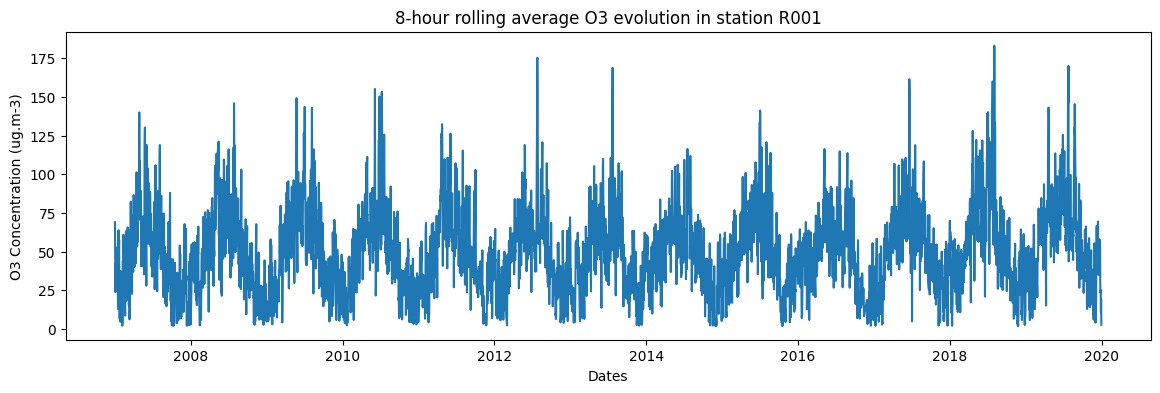

In [31]:
plt.figure(figsize=(14,4))
plt.title('8-hour rolling average O3 evolution in station R001')
plt.xlabel('Dates')
plt.ylabel('O3 Concentration (ug.m-3)')
plt.plot(data_a.Concentration)

In [32]:
data_b = data_a.copy()
data_b = data_b.reset_index()

In [33]:
data_b

,Date,Concentration
0,2007-01-01,69.0000
1,2007-01-02,44.3750
2,2007-01-03,23.7500
3,2007-01-04,41.8750
4,2007-01-05,29.3750
...,...,...
4735,2019-12-27,23.3750
4736,2019-12-28,25.0000
4737,2019-12-29,10.7500
4738,2019-12-30,19.1875


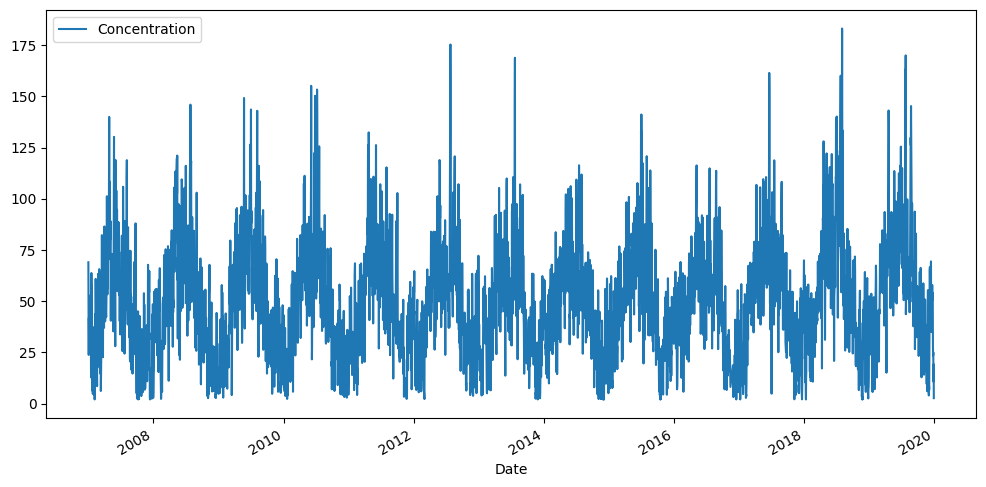

In [34]:
data_b['Date'] = pd.to_datetime(data_b['Date'])  # Convert date column to DateTime
ax = data_b.plot(x='Date', y='Concentration', figsize=(12, 6))

plt.show()

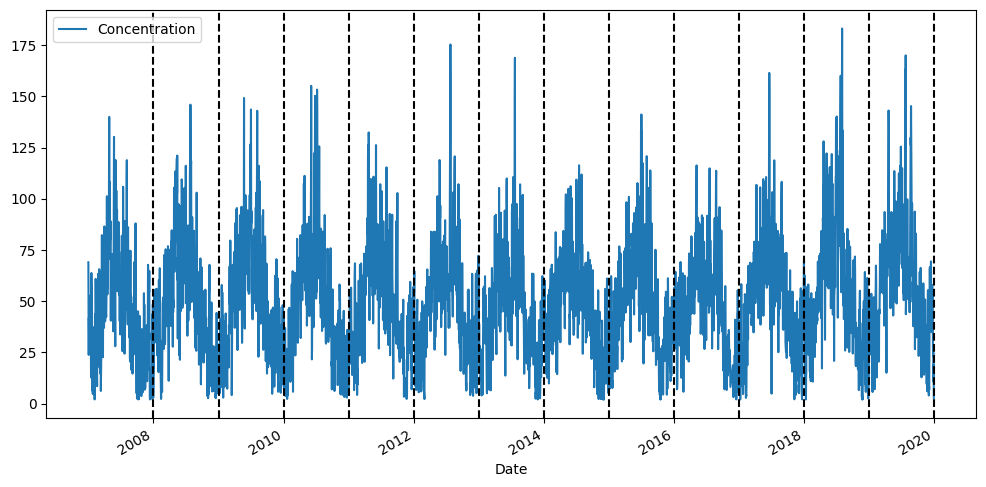

In [35]:
ax = data_b.plot(x='Date', y='Concentration', figsize=(12,6))
xcoords = ['2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01','2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

We can slightly observe seasonality

In [36]:
data_a.dropna(subset=['Concentration'], inplace=True)

In [37]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data_a)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

ADF Statistic: -4.756771056241194
p-value: 6.574507419707421e-05
Critical Values: {'1%': -3.4317400296926333, '5%': -2.862154234399525, '10%': -2.5670969591609873}
The time series is likely stationary.


## Analysed stationarity

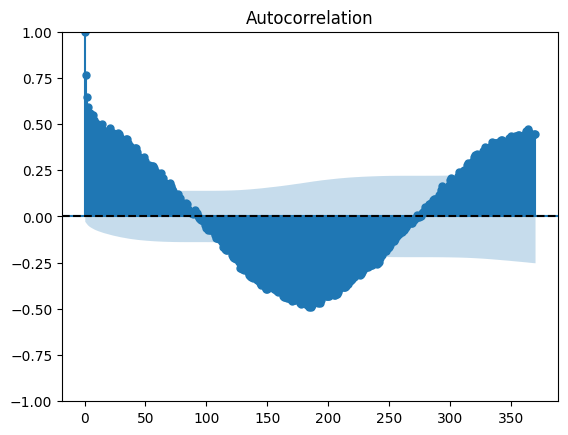

In [38]:
acf_plot = plot_acf(data_a.Concentration, lags=370)
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

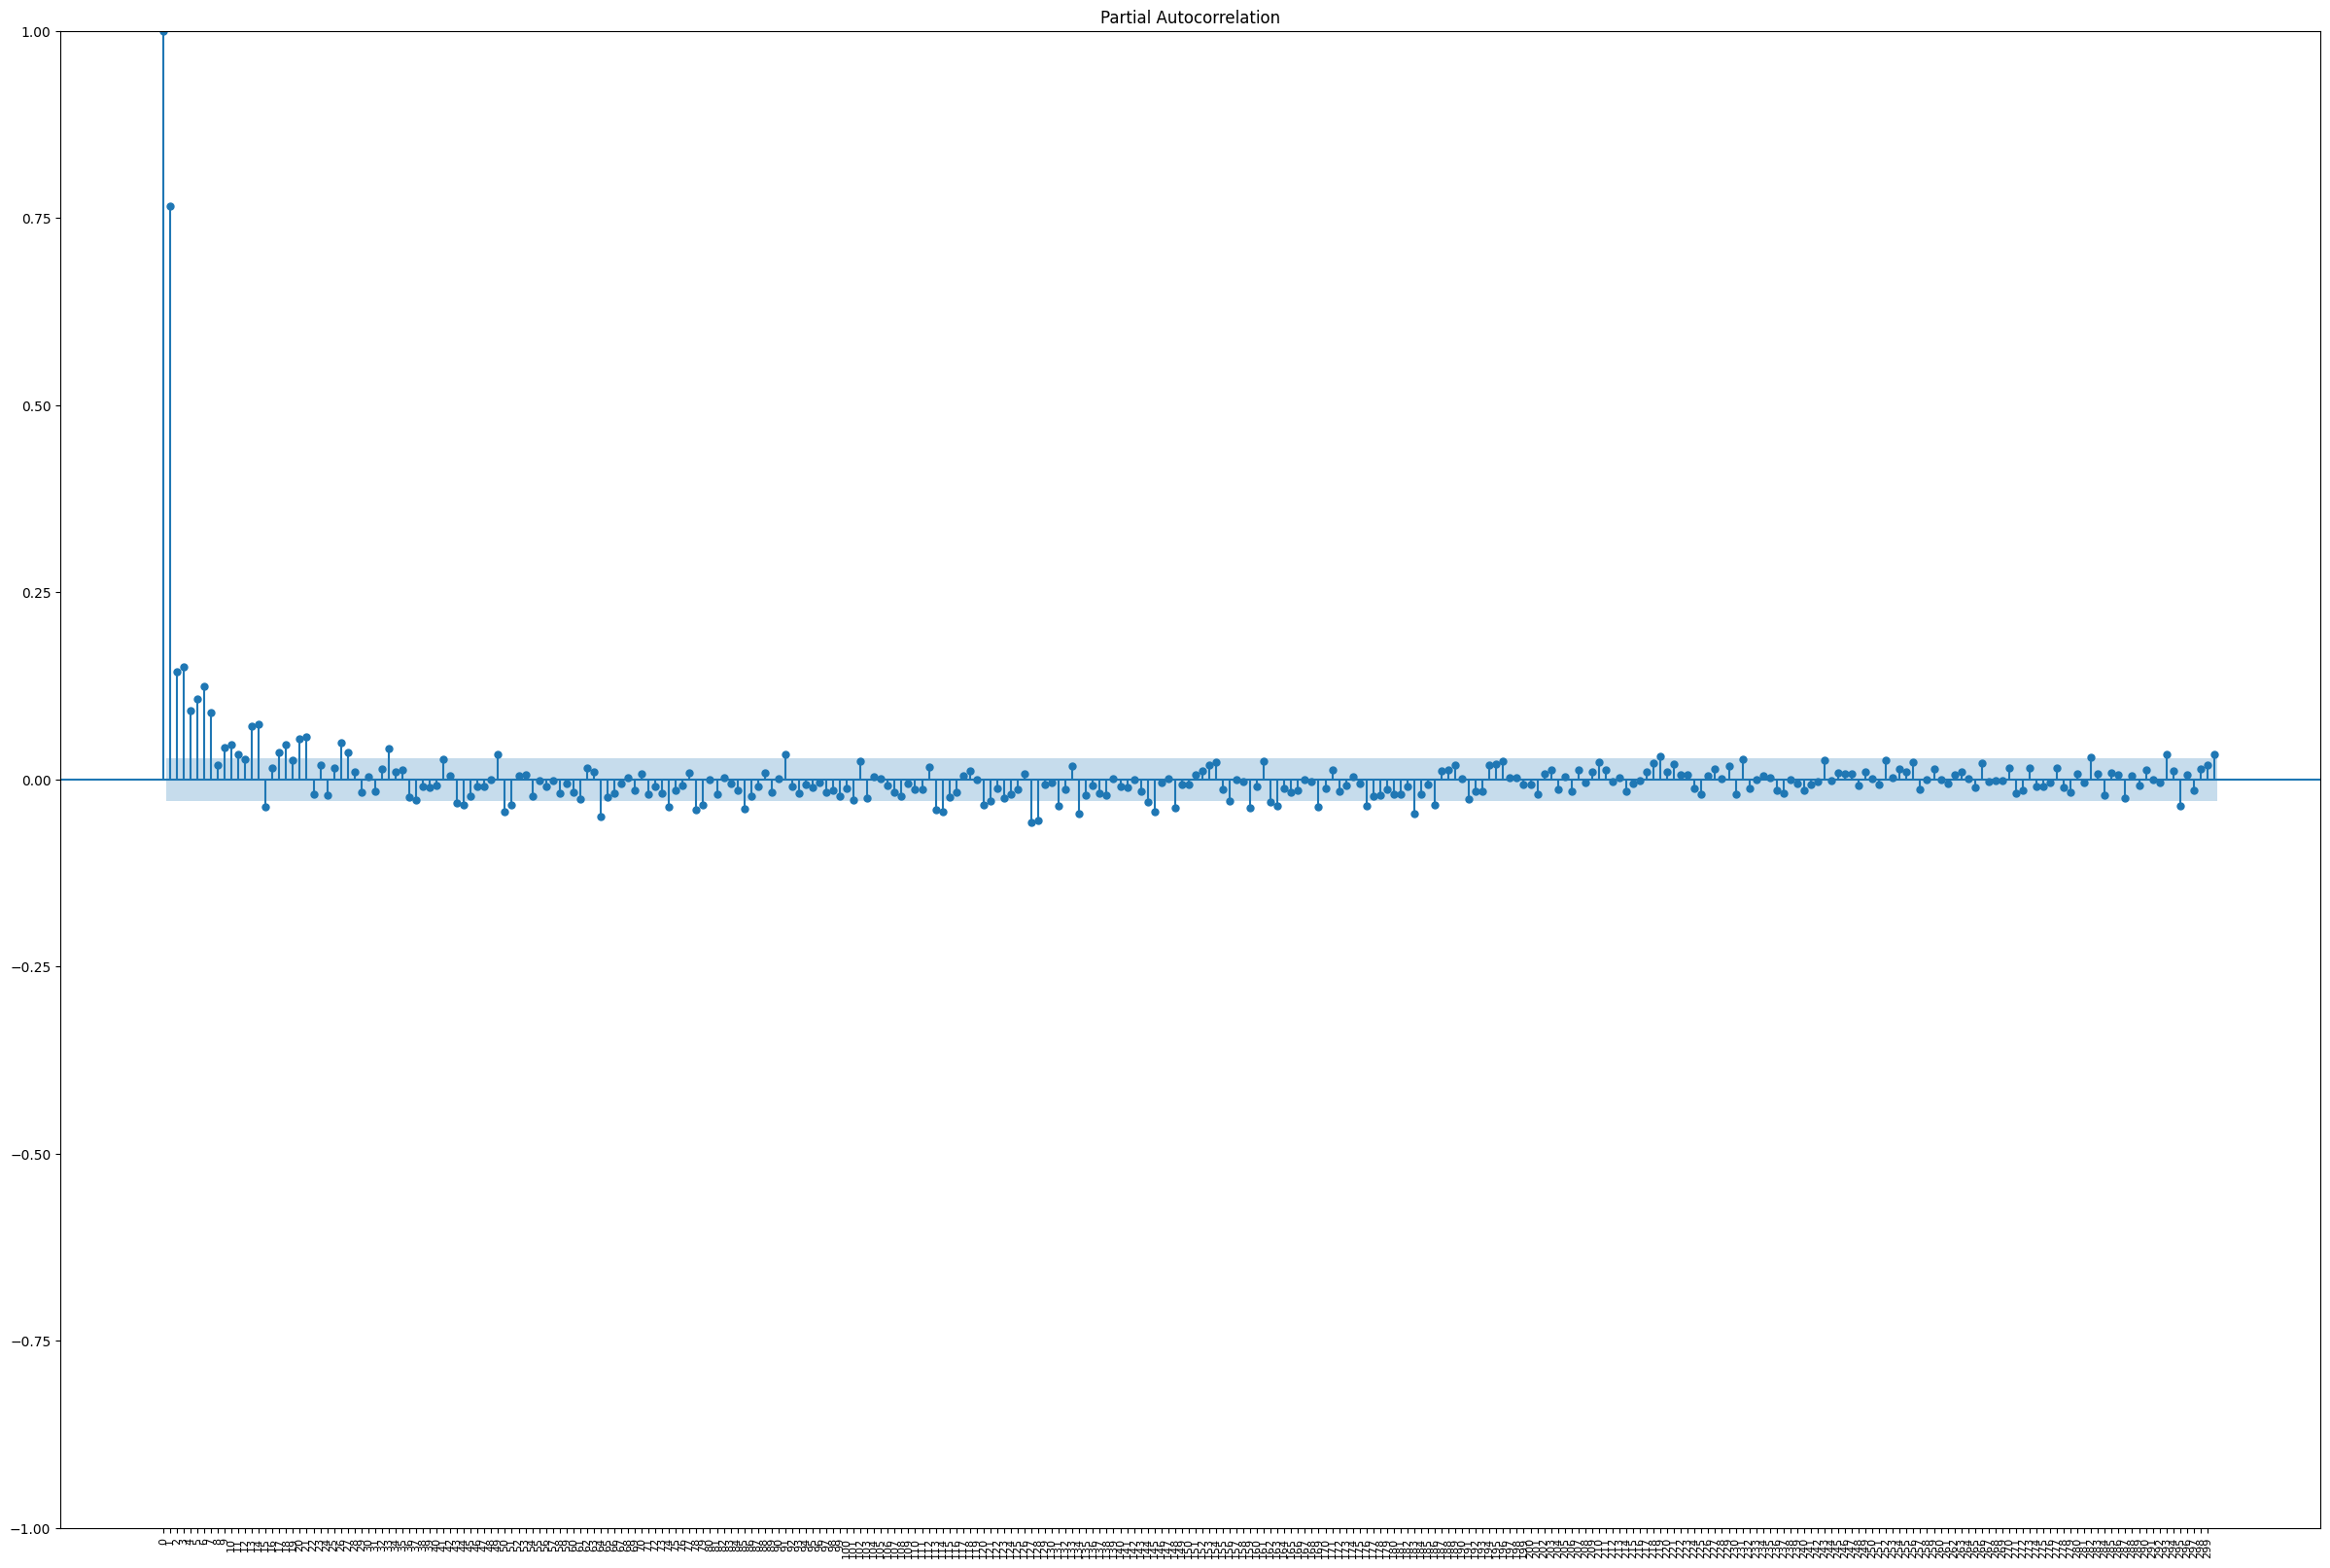

In [39]:
# Assuming you have a figure and axis
fig, ax = plt.subplots(figsize=(30, 20))

# Assuming your DataFrame is named 'data_a'
pacf_plot = plot_pacf(data_a['Concentration'], lags=300, ax=ax)

# Display the plot
plt.xticks(range(300), rotation='vertical', fontsize=8)
plt.show()

## ARIMA BLOCK OF CODE

In [40]:
"""
# Define the range of AR, MA, and seasonality values to check
ar_range = range(12)
ma_range = range(12)

# Initialize variables for tracking the best model
best_mse = float('inf')
best_order = None
best_results = None

# Iterate through AR and MA values
for p in ar_range:
    for q in ma_range:
        order = (p, 0, q)  # ARIMA order (p, d, q), here d=0 for ARMA
        model = sm.tsa.ARIMA(data_a['Concentration'], order=order)
        results = model.fit()

        # Calculate Mean Squared Error (MSE)
        fitted_values = results.fittedvalues
        mse = mean_squared_error(data_a['Concentration'], fitted_values)

        # Check if the current model has a lower MSE than the best so far
        if mse < best_mse:
            best_mse = mse
            best_order = order
            best_results = results

# Display the best model's information including AIC, BIC, MSE, and summary
print(f'Best Model Order: {best_order}')
print(f'Best Model AIC: {best_results.aic:.2f}')
print(f'Best Model BIC: {best_results.bic:.2f}')
print(f'Best Model MSE: {best_mse:.2f}')
print(best_results.summary())
"""

"\n# Define the range of AR, MA, and seasonality values to check\nar_range = range(12)\nma_range = range(12)\n\n# Initialize variables for tracking the best model\nbest_mse = float('inf')\nbest_order = None\nbest_results = None\n\n# Iterate through AR and MA values\nfor p in ar_range:\n    for q in ma_range:\n        order = (p, 0, q)  # ARIMA order (p, d, q), here d=0 for ARMA\n        model = sm.tsa.ARIMA(data_a['Concentration'], order=order)\n        results = model.fit()\n\n        # Calculate Mean Squared Error (MSE)\n        fitted_values = results.fittedvalues\n        mse = mean_squared_error(data_a['Concentration'], fitted_values)\n\n        # Check if the current model has a lower MSE than the best so far\n        if mse < best_mse:\n            best_mse = mse\n            best_order = order\n            best_results = results\n\n# Display the best model's information including AIC, BIC, MSE, and summary\nprint(f'Best Model Order: {best_order}')\nprint(f'Best Model AIC: {best

In [41]:
best_order = (11, 0, 10)

In [42]:
# Fit ARMA (11, 0, 10)
order_arma = best_order  # ARIMA order (p, d, q), here d=0 for ARMA
model_arma = sm.tsa.ARIMA(data_a['Concentration'], order=order_arma)
results_arma = model_arma.fit()

# Extract the predicted (fitted) values
fitted_values = pd.DataFrame({
    'FittedValues': results_arma.fittedvalues
})

# Combine the original data_a DataFrame with the fitted values
data['FittedValues'] = fitted_values['FittedValues']

# Display the updated DataFrame
print(data)

results_arma.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            Year  Month  Day  Concentration  DayOfWeek  Weekend  lagged_ma_7  \
Date                                                                           
2007-01-01  2007      1    1        69.0000          1        0          NaN   
2007-01-02  2007      1    2        44.3750          2        0          NaN   
2007-01-03  2007      1    3        23.7500          3        0          NaN   
2007-01-04  2007      1    4        41.8750          4        0          NaN   
2007-01-05  2007      1    5        29.3750          5        0          NaN   
...          ...    ...  ...            ...        ...      ...          ...   
2019-12-27  2019     12   27        23.3750          5        0    50.035714   
2019-12-28  2019     12   28        25.0000          6        1    45.375000   
2019-12-29  2019     12   29        10.7500          0        1    41.678571   
2019-12-30  2019     12   30        19.1875          1        0    34.946429   
2019-12-31  2019     12   31         2.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Concentration   No. Observations:                 4740
Model:               ARIMA(11, 0, 10)   Log Likelihood              -19947.922
Date:                Wed, 29 May 2024   AIC                          39941.844
Time:                        10:52:35   BIC                          40090.512
Sample:                             0   HQIC                         39994.091
                               - 4740                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.8000      4.970     10.020      0.000      40.059      59.541
ar.L1          0.2711      0.562      0.482      0.630      -0.830       1.373
ar.L2          0.2597      0.269      0.966      0.334      -0.267       0.787
ar.L3          0.4485      0.247      1.818      0.069      -0.035       0.932
ar.L4         -0.2021      0.161     -1.256      0.209      -0.517       0.113
ar.L5         -0.1134      0.080     -1.417      0.156      -0.270       0.043
ar.L6          0.1384      0.091      1.521      0.128      -0.040       0.317
ar.L7          0.8389      0.093      9.044      0.000       0.657       1.021
ar.L8         -0.1400      0.511     -0.274      0.784      -1.142       0.862
ar.L9         -0.3359      0.262     -1.281      0.200      -0.850       0.178
ar.L10        -0.4297      0.232     -1.854      0.064      -0.884       0.025
ar.L11         0.2484      0.144      1.727      0.084      -0.034       0.530
ma.L1          0.2916      0.562      0.519      0.604      -0.809       1.393
ma.L2         -0.0706      0.416     -0.170      0.865      -0.886       0.745
ma.L3         -0.4075      0.325     -1.254      0.210      -1.044       0.229
ma.L4         -0.0028      0.101     -0.028      0.977      -0.200       0.195
ma.L5          0.1383      0.090      1.542      0.123      -0.037       0.314
ma.L6         -0.0566      0.131     -0.433      0.665      -0.313       0.200
ma.L7         -0.8222      0.086     -9.600      0.000      -0.990      -0.654
ma.L8         -0.3356      0.438     -0.767      0.443      -1.193       0.522
ma.L9          0.1352      0.342      0.396      0.692      -0.534       0.805
ma.L10         0.4357      0.245      1.777      0.076      -0.045       0.916
sigma2       267.4720      4.571     58.516      0.000     258.513     276.431
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               286.88
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.20
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model not valid as Ljung-Box test is 0.00.

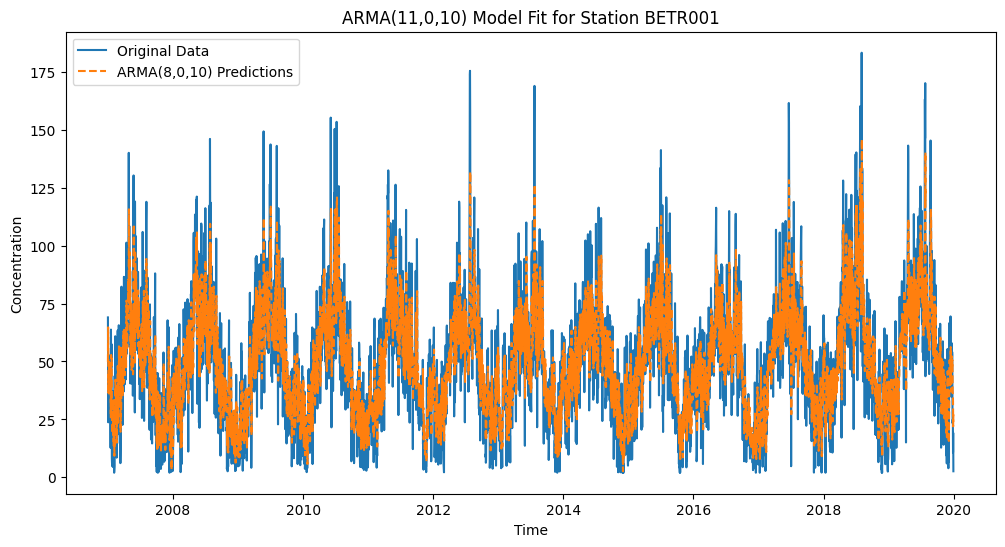

In [43]:
# Plot original data and predicted values
plt.figure(figsize=(12, 6))
plt.plot(data_a, label='Original Data')
plt.plot(results_arma.fittedvalues, label='ARMA(8,0,10) Predictions', linestyle='--')
plt.title('ARMA(11,0,10) Model Fit for Station BETR001')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

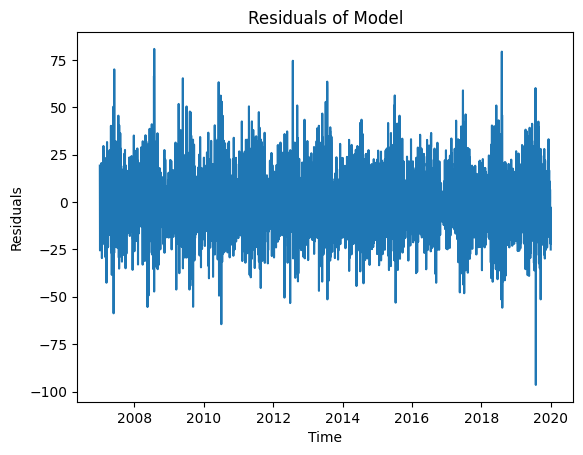

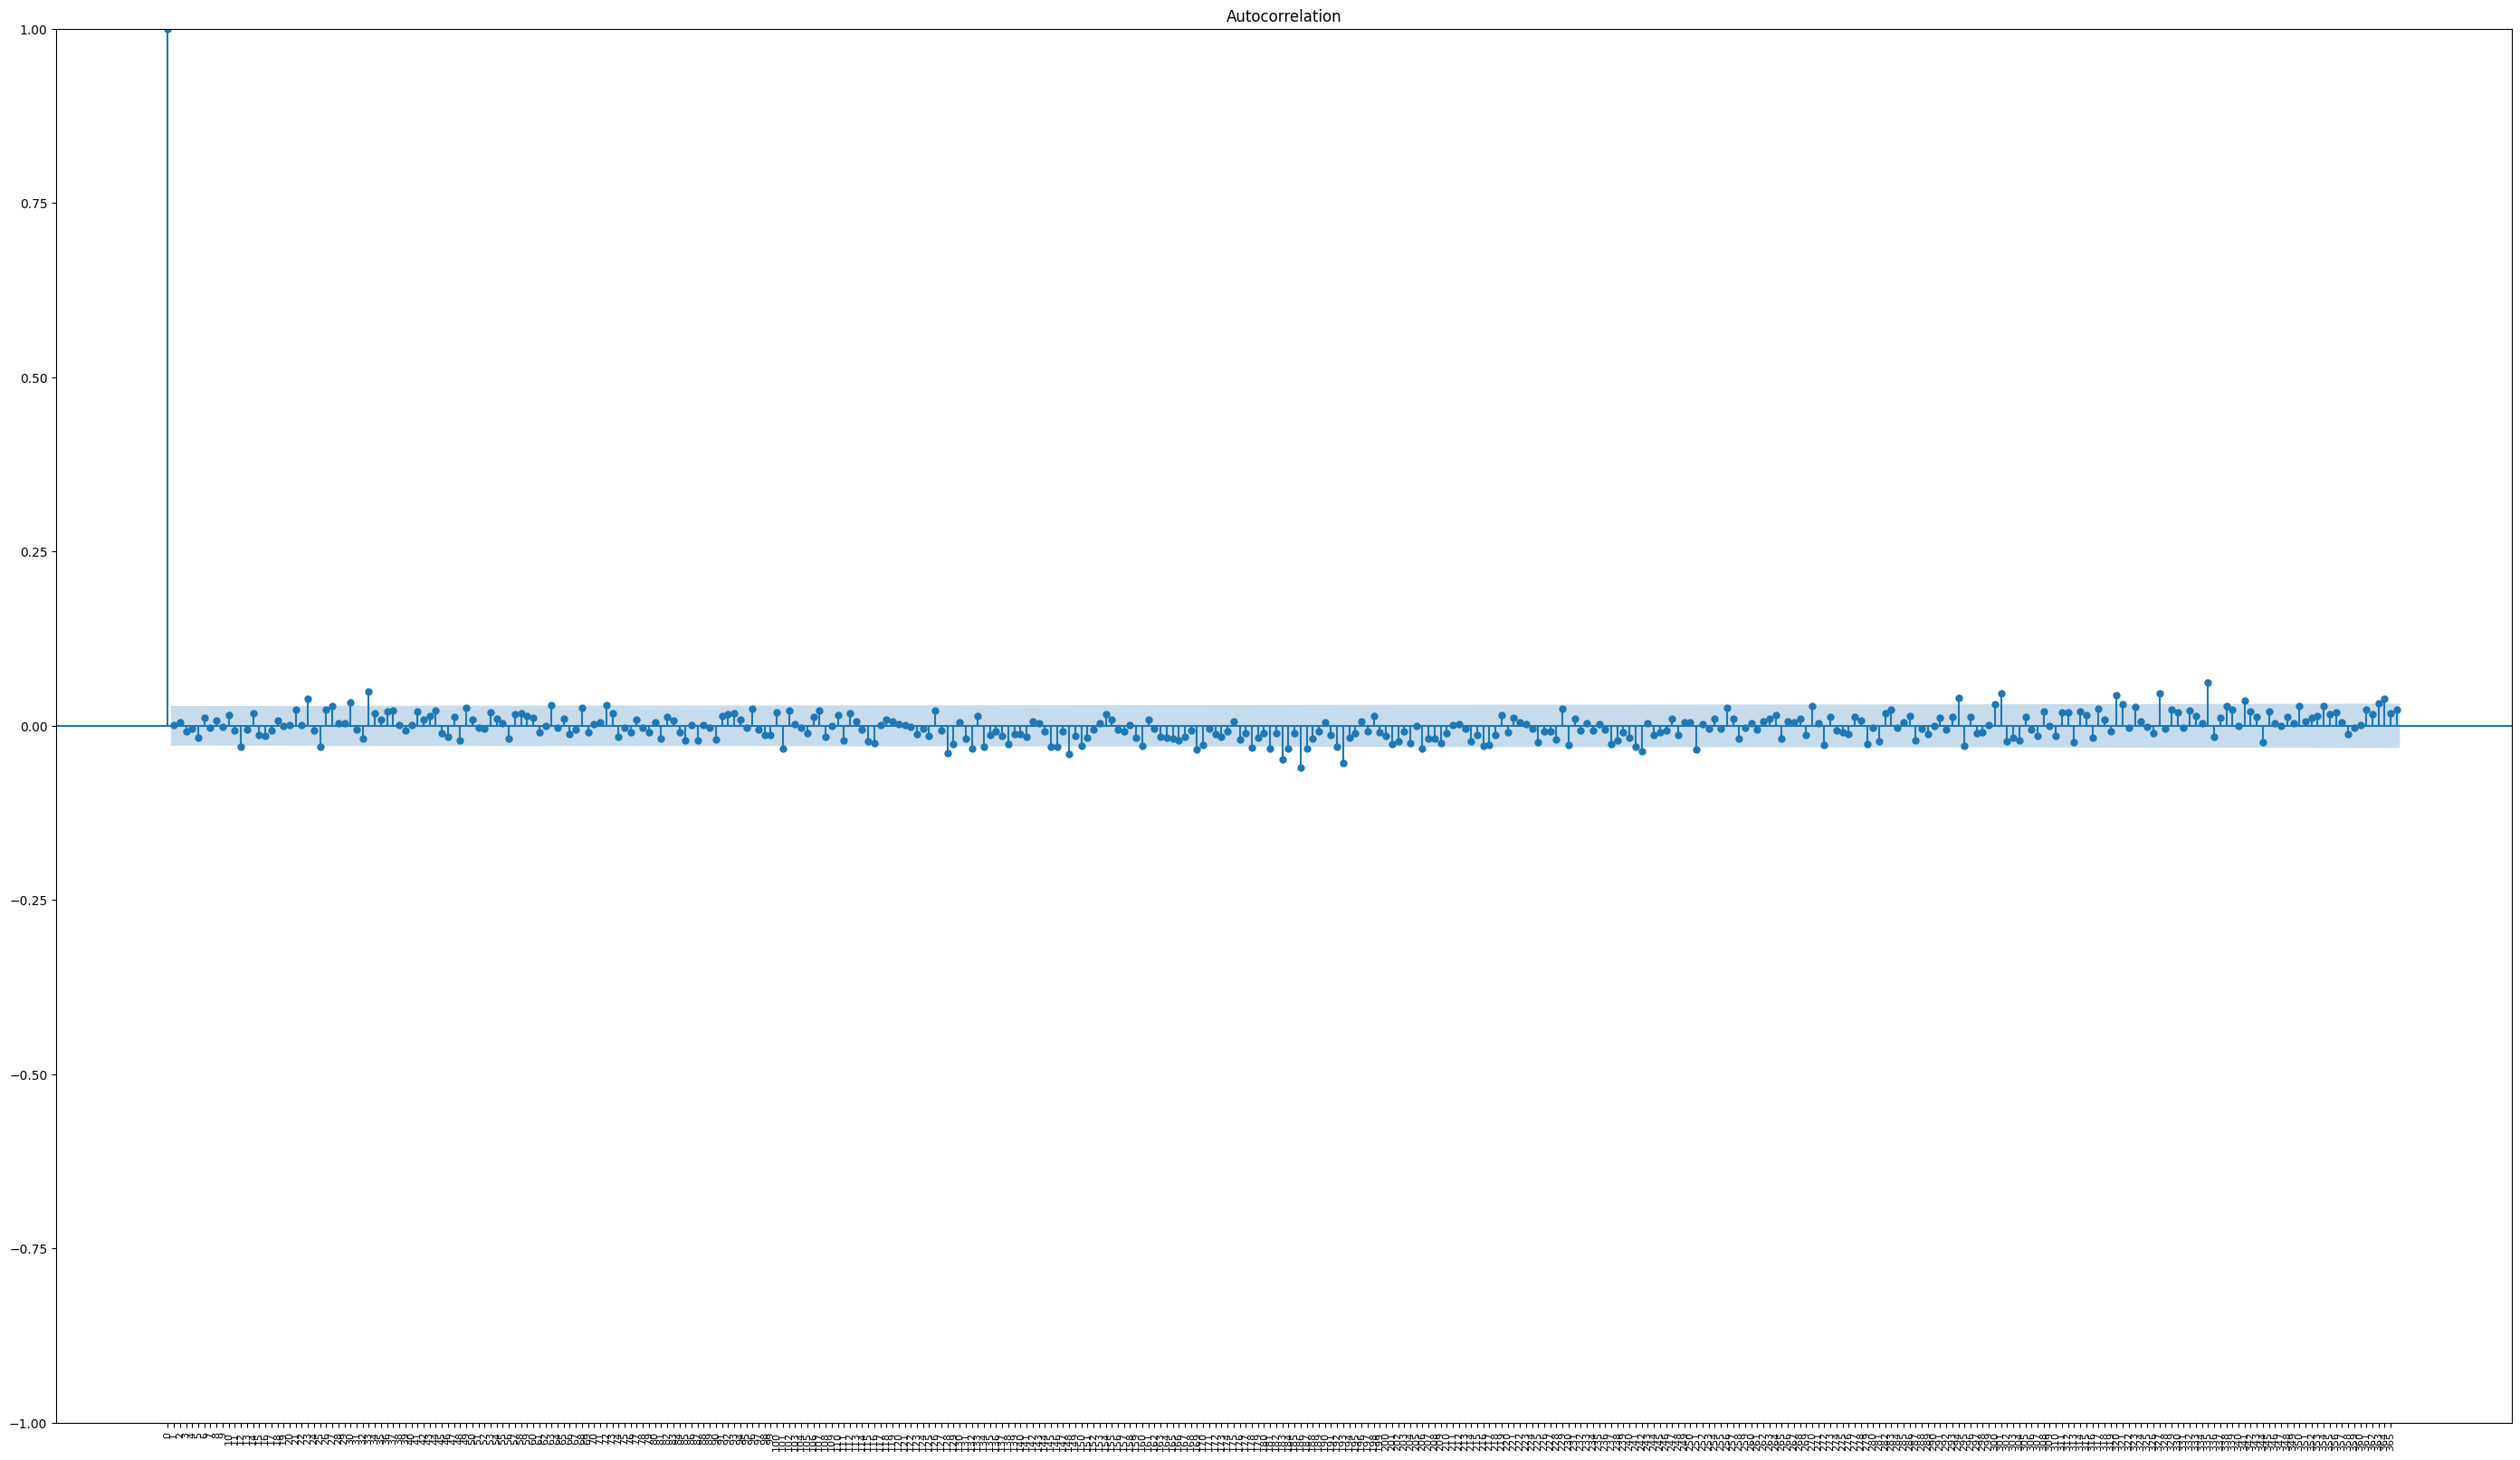

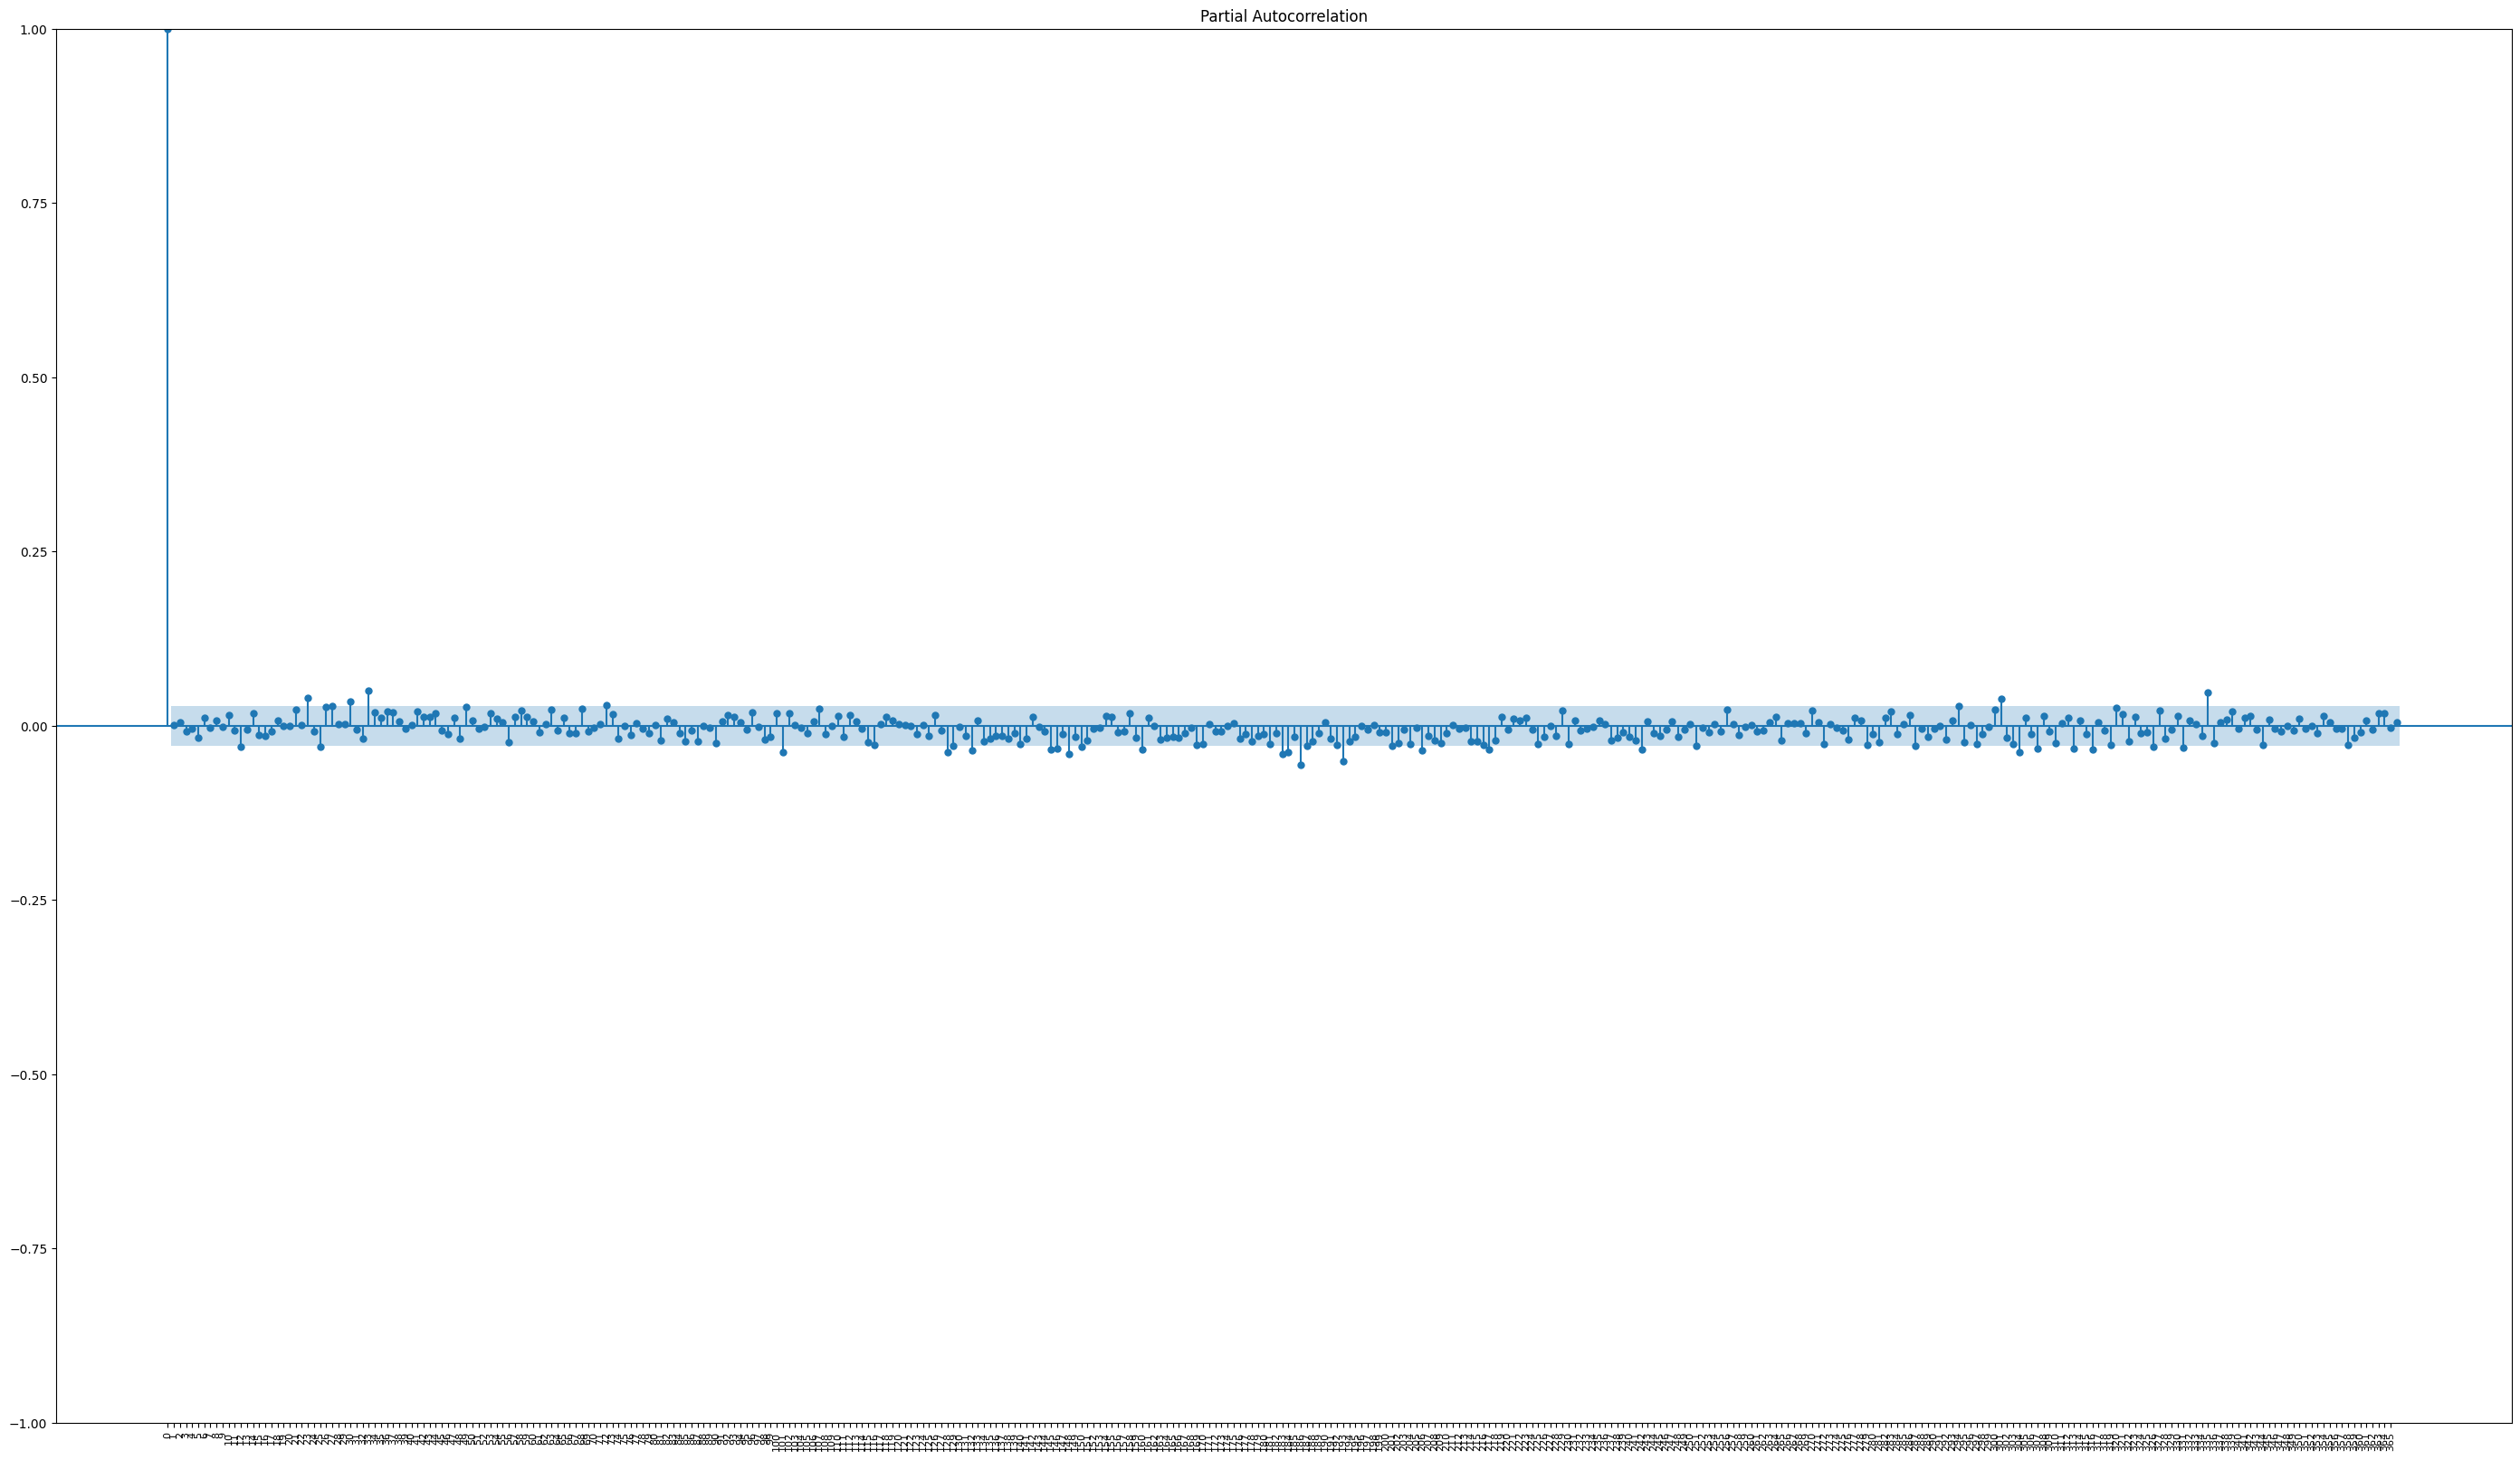

In [44]:
residuals = results_arma.resid

# Plot the residuals
plt.plot(residuals)
plt.title('Residuals of Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plot ACF and PACF of residuals
fig, ax = plt.subplots(figsize=(35, 20))

# Assuming your DataFrame is named 'data_a'
acf_plot = plot_acf(residuals, lags=366, ax=ax)

# Display the plot
plt.xticks(range(366), rotation='vertical', fontsize=8)
plt.show()


# Assuming you have a figure and axis
fig, ax = plt.subplots(figsize=(35, 20))

# Assuming your DataFrame is named 'data_a'
pacf_plot = plot_pacf(residuals, lags=366, ax=ax)

# Display the plot
plt.xticks(range(366), rotation='vertical', fontsize=8)
plt.show()

In [45]:
# Remove NaN values from 'Concentration' and 'FittedValues' columns
mask = ~np.isnan(data['Concentration']) & ~np.isnan(data['FittedValues'])
y_true = data['Concentration'][mask]
y_pred = data['FittedValues'][mask]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

Mean Squared Error (MSE): 267.09


The MSE is very high, its 267.09

## Lagged values of Concentration feature creation (value from day before, a week before, a month before, and a year before)

In [46]:
# Assuming 'Date' is your index
data['day_lag1'] = data['Concentration'].shift(1)
data['day_lag7'] = data['Concentration'].shift(7)
data['day_fut1'] = data['Concentration'].shift(-1)
data['day_fut7'] = data['Concentration'].shift(-7)

In [47]:
# Assuming data is your DataFrame

#For month
def get_previous_day_concentration(row, data):
    prev_month = row['Month'] - 1
    prev_year = row['Year']
    prev_day = row['Day']

    if prev_month == 0:  # If the previous month is December, adjust year and month
        prev_month = 12
        prev_year -= 1

    # Check if previous day exists in the previous month
    prev_day_concentration = data.loc[
        (data['Year'] == prev_year) &
        (data['Month'] == prev_month) &
        (data['Day'] == prev_day),
        'Concentration'
    ]

    # If the previous day's concentration is not found, check the last day of the previous month
    if prev_day_concentration.empty:
        # Adjusting to the last day of the previous month (30 or 31)
        prev_day = 30 if prev_month in [4, 6, 9, 11] else 31 if prev_month != 2 else 28  # February special case
        prev_day_concentration = data.loc[
            (data['Year'] == prev_year) &
            (data['Month'] == prev_month) &
            (data['Day'] == prev_day),
            'Concentration'
        ]

    return prev_day_concentration.iloc[0] if not prev_day_concentration.empty else np.nan

data['day_lag30'] = data.apply(lambda row: get_previous_day_concentration(row, data) if row['Month'] > 1 else np.nan, axis=1)

#For future month
# Assuming data is your DataFrame

def get_next_day_concentration(row, data):
    next_month = row['Month'] + 1
    next_year = row['Year']
    next_day = row['Day']

    if next_month == 13:  # If the next month is January, adjust year and month
        next_month = 1
        next_year += 1

    # Check if next day exists in the next month
    next_day_concentration = data.loc[
        (data['Year'] == next_year) &
        (data['Month'] == next_month) &
        (data['Day'] == next_day),
        'Concentration'
    ]

    # If the next day's concentration is not found, check the last day of the next month
    if next_day_concentration.empty:
        # Adjusting to the last day of the next month (30 or 31)
        next_day = 30 if next_month in [4, 6, 9, 11] else 31 if next_month != 2 else 28  # February special case
        next_day_concentration = data.loc[
            (data['Year'] == next_year) &
            (data['Month'] == next_month) &
            (data['Day'] == next_day),
            'Concentration'
        ]

    return next_day_concentration.iloc[0] if not next_day_concentration.empty else np.nan

data['day_fut30'] = data.apply(lambda row: get_next_day_concentration(row, data) if row['Month'] < 12 else np.nan, axis=1)

#for last year
data['day_lag365'] = data.apply(
    lambda row: data.loc[
        (data['Year'] == row['Year'] - 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].iloc[0] if row['Year'] > data['Year'].min() and not data.loc[
        (data['Year'] == row['Year'] - 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].empty else np.nan, axis=1
)

#For future year
data['day_fut365'] = data.apply(
    lambda row: data.loc[
        (data['Year'] == row['Year'] + 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].iloc[0] if row['Year'] > data['Year'].min() and not data.loc[
        (data['Year'] == row['Year'] + 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].empty else np.nan, axis=1
)

In [48]:
# Columns to calculate MSE for
lag_columns = ['day_lag1', 'day_lag7', 'day_fut1', 'day_fut7', 'day_lag30', "day_fut30", 'day_lag365', 'day_fut365']

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through lag columns and calculate MSE for dropped DataFrame
for lag_column in lag_columns:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[lag_column], squared=True)
    mae_dropped = mean_absolute_error(data_dropped['Concentration'], data_dropped[lag_column])
    print(f'MSE for {lag_column} with dropped values: {mse_dropped}')
    print(f'MAE for {lag_column} with dropped values: {mae_dropped}')

MSE for day_lag1 with dropped values: 373.3285634296822
MAE for day_lag1 with dropped values: 14.66696247464503
MSE for day_lag7 with dropped values: 689.5958576318459
MAE for day_lag7 with dropped values: 19.7539722785666
MSE for day_fut1 with dropped values: 376.2689079403313
MAE for day_fut1 with dropped values: 14.694388100067613
MSE for day_fut7 with dropped values: 678.4959815014367
MAE for day_fut7 with dropped values: 19.62049949290061
MSE for day_lag30 with dropped values: 916.3850020072684
MAE for day_lag30 with dropped values: 23.62153482082488
MSE for day_fut30 with dropped values: 920.232759941261
MAE for day_fut30 with dropped values: 23.659841954022987
MSE for day_lag365 with dropped values: 760.7511621027721
MAE for day_lag365 with dropped values: 21.093855645706558
MSE for day_fut365 with dropped values: 764.2124693627451
MAE for day_fut365 with dropped values: 21.0216784989858


In [49]:
variables_to_check = ['day_lag1', 'day_lag7', 'day_fut1', 'day_fut7', 'day_lag30', "day_fut30", 'day_lag365', 'day_fut365']

missing_counts = {variable: data[variable].isnull().sum() for variable in variables_to_check}

for variable, missing_count in missing_counts.items():
    print(f"Missing values in {variable}: {missing_count}")

Missing values in day_lag1: 53
Missing values in day_lag7: 59
Missing values in day_fut1: 53
Missing values in day_fut7: 59
Missing values in day_lag30: 460
Missing values in day_fut30: 461
Missing values in day_lag365: 423
Missing values in day_fut365: 783


# Extra PreProc

## Introduction of Holiday variable

In [50]:
# List of holiday dates with months and days
holiday_dates = {
    (1, 1),   # New Year's Day
    (1, 6),   # Epiphany
    (2, 14),  # Valentine's Day
    (3, 20),  # March Equinox
    (3, 29),  # Good Friday
    (3, 31),  # Easter Sunday
    (4, 1),   # Easter Monday
    (5, 1),   # Labor Day / May Day
    (5, 8),   # Iris Day (Brussels Regional holiday)
    (5, 9),   # Ascension Day
    (5, 10),  # Day after Ascension Day
    (5, 12),  # Mothers' Day
    (5, 19),  # Whit Sunday
    (5, 20),  # Whit Monday
    (6, 9),   # Fathers' Day
    (6, 20),  # June Solstice
    (7, 11),  # Day of the Flemish Community (Regional holiday in some provinces)
    (7, 21),  # Belgian National Day
    (8, 15),  # Assumption of Mary
    (9, 15),  # Day of the Walloon Region (Regional holiday in Namur)
    (9, 22),  # September Equinox
    (9, 27),  # Day of the French Community (Regional holiday in some provinces)
    (10, 27), # Daylight Saving Time ends
    (10, 31), # Halloween
    (11, 1),  # All Saints' Day
    (11, 11), # Armistice Day
    (11, 15), # Day of the German-speaking Community (Regional holiday in Liège)
    (12, 6),  # St. Nicholas Day
    (12, 21), # December Solstice
    (12, 24), # Christmas Eve
    (12, 25), # Christmas Day
    (12, 26), # Boxing Day
    (12, 31)  # New Year's Eve
}

# Create a new column 'IsHoliday' and set it to 1 for holidays, 0 otherwise
data['IsHoliday'] = data.apply(lambda row: 1 if (row['Month'], row['Day']) in holiday_dates else 0, axis=1)

## Introduction of Season Variable

In [51]:
# Define the season based on the month with numerical values
data['Season'] = data['Month'].apply(lambda x:
                                     1 if (x == 12 or x <= 2) else
                                     2 if (x >= 3 and x <= 5) else
                                     3 if (x >= 6 and x <= 8) else
                                     4 if (x >= 9 and x <= 11) else None)

# Display the updated DataFrame
print(data)
data['Season'].unique()

            Year  Month  Day  Concentration  DayOfWeek  Weekend  lagged_ma_7  \
Date                                                                           
2007-01-01  2007      1    1        69.0000          1        0          NaN   
2007-01-02  2007      1    2        44.3750          2        0          NaN   
2007-01-03  2007      1    3        23.7500          3        0          NaN   
2007-01-04  2007      1    4        41.8750          4        0          NaN   
2007-01-05  2007      1    5        29.3750          5        0          NaN   
...          ...    ...  ...            ...        ...      ...          ...   
2019-12-27  2019     12   27        23.3750          5        0    50.035714   
2019-12-28  2019     12   28        25.0000          6        1    45.375000   
2019-12-29  2019     12   29        10.7500          0        1    41.678571   
2019-12-30  2019     12   30        19.1875          1        0    34.946429   
2019-12-31  2019     12   31         2.6

array([1, 2, 3, 4])

## One-Hot Encoding

In [52]:
data['Winter'] = np.where(data['Season'] == 1, 1, 0)
data['Spring'] = np.where(data['Season'] == 2, 1, 0)
data['Summer'] = np.where(data['Season'] == 3, 1, 0)
data['Autumn'] = np.where(data['Season'] == 4, 1, 0)

data = data.drop(columns='Season')

# Weather and Other Pollutant Data

In [53]:
weather_data = pd.read_csv("weather_data_full.csv")

In [54]:
pm_average = pd.read_csv("pm_data_averaged.csv")

In [55]:
pm_all = pd.read_csv("pm_data_allstations.csv")

In [56]:
# Convert 'Date' columns to datetime type if they are not already
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
pm_average['Date'] = pd.to_datetime(pm_average['Date'])
pm_all['Date'] = pd.to_datetime(pm_all['Date'])

# Merge the datasets on 'Date' column
data = data.reset_index()  # Reset index to make 'Date' a regular column
merged_data = data.merge(weather_data, on='Date', how='outer')
merged_data = merged_data.merge(pm_average, on='Date', how='outer')
merged_data = merged_data.merge(pm_all, on='Date', how='outer')

# Set 'Date' column as index again
merged_data.set_index('Date', inplace=True)

In [57]:
merged_data

,Year,Month,Day,Concentration,DayOfWeek,Weekend,lagged_ma_7,lagged_mm_7,FittedValues,day_lag1,...,pm_25,pm25_BETR012,pm25_BETR001,pm25_BETN043,pm25_BETB011,pm10_BETR012,pm10_BETR001,pm10_BETN043,pm10_BETB011,pm10_BETWOL1
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,2007.0,1.0,1.0,69.000,1.0,0.0,NaN,NaN,49.799978,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-02,2007.0,1.0,2.0,44.375,2.0,0.0,NaN,NaN,64.716474,69.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-03,2007.0,1.0,3.0,23.750,3.0,0.0,NaN,NaN,49.288073,44.375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-04,2007.0,1.0,4.0,41.875,4.0,0.0,NaN,NaN,36.534359,23.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,2007.0,1.0,5.0,29.375,5.0,0.0,NaN,NaN,45.045576,41.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Adding other stations

In [58]:
other_stations = pd.read_csv("Data/stations_data.csv")

In [59]:
# Assuming 'o3_r001' is a column in other_stations DataFrame
other_stations.drop(columns=['o3_r001'], inplace=True)

In [60]:
other_stations

,o3_b011,o3_n043,o3_r012,o3_r701,o3_r710,o3_r801,o3_r811,o3_r831,o3_wol1
0,5.7500,14.500,11.0000,5.2500,8.500,10.1250,18.2500,12.0000,7.6250
1,19.8750,24.000,23.8750,17.0000,19.750,9.5000,22.5000,21.5000,17.8750
2,19.7500,22.500,32.8750,20.3750,25.875,11.3750,34.0000,33.8750,22.6250
3,13.8750,29.750,37.0000,21.1250,30.375,8.5000,17.3750,7.5000,13.1250
4,66.0000,55.750,66.7500,46.7500,53.750,41.8750,53.5000,43.2500,53.8750
...,...,...,...,...,...,...,...,...,...
4013,5.7500,3.250,15.1250,6.2500,4.250,NaN,2.1875,3.1250,4.7500
4014,3.0625,2.250,5.0000,1.3125,0.500,NaN,0.3750,0.1250,2.3750
4015,16.2500,6.750,19.2500,6.9375,9.125,15.5000,8.5000,7.5000,10.1875
4016,25.1875,13.375,22.8125,22.4375,20.250,31.5625,54.3125,46.5000,17.3750


In [61]:
# Create a date range from 2008-01-01 to 2018-12-31
date_range = pd.date_range(start='2008-01-01', end='2018-12-31', freq='D')

# Create a DataFrame with the date range
date_df = pd.DataFrame({'Date': date_range})

# Add the 'Date' column to other_stations DataFrame
other_stations['Date'] = date_df['Date']

# Display the DataFrame
print(other_stations)

      o3_b011  o3_n043  o3_r012  o3_r701  o3_r710  o3_r801  o3_r811  o3_r831  \
0      5.7500   14.500  11.0000   5.2500    8.500  10.1250  18.2500  12.0000   
1     19.8750   24.000  23.8750  17.0000   19.750   9.5000  22.5000  21.5000   
2     19.7500   22.500  32.8750  20.3750   25.875  11.3750  34.0000  33.8750   
3     13.8750   29.750  37.0000  21.1250   30.375   8.5000  17.3750   7.5000   
4     66.0000   55.750  66.7500  46.7500   53.750  41.8750  53.5000  43.2500   
...       ...      ...      ...      ...      ...      ...      ...      ...   
4013   5.7500    3.250  15.1250   6.2500    4.250      NaN   2.1875   3.1250   
4014   3.0625    2.250   5.0000   1.3125    0.500      NaN   0.3750   0.1250   
4015  16.2500    6.750  19.2500   6.9375    9.125  15.5000   8.5000   7.5000   
4016  25.1875   13.375  22.8125  22.4375   20.250  31.5625  54.3125  46.5000   
4017  27.8750   15.250  19.6250  22.2500   25.250  25.6875  26.6875  26.3125   

      o3_wol1       Date  
0      7.625

In [62]:
# Merge merged_data with other_stations on 'Date' column
merged_data = merged_data.reset_index()  # Reset index to make 'Date' a regular column
merged_data = merged_data.merge(other_stations, on='Date', how='outer')

# Set 'Date' column as index again
merged_data.set_index('Date', inplace=True)

In [63]:
merged_data

,Year,Month,Day,Concentration,DayOfWeek,Weekend,lagged_ma_7,lagged_mm_7,FittedValues,day_lag1,...,pm10_BETWOL1,o3_b011,o3_n043,o3_r012,o3_r701,o3_r710,o3_r801,o3_r811,o3_r831,o3_wol1
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,2007.0,1.0,1.0,69.000,1.0,0.0,NaN,NaN,49.799978,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-02,2007.0,1.0,2.0,44.375,2.0,0.0,NaN,NaN,64.716474,69.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-03,2007.0,1.0,3.0,23.750,3.0,0.0,NaN,NaN,49.288073,44.375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-04,2007.0,1.0,4.0,41.875,4.0,0.0,NaN,NaN,36.534359,23.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,2007.0,1.0,5.0,29.375,5.0,0.0,NaN,NaN,45.045576,41.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
data = merged_data.copy()

# Complete Dataframe

In [65]:
# Check for missing values in the 'Concentration' column
rows_with_missing_values = data[data['Concentration'].isna()]

# Display rows with missing values
print("Rows with missing values in 'Concentration' column:")
print(rows_with_missing_values)

Rows with missing values in 'Concentration' column:
              Year  Month   Day  Concentration  DayOfWeek  Weekend  \
Date                                                                 
2007-02-06  2007.0    2.0   6.0            NaN        2.0      0.0   
2007-03-13  2007.0    3.0  13.0            NaN        2.0      0.0   
2007-03-14  2007.0    3.0  14.0            NaN        3.0      0.0   
2007-10-09  2007.0   10.0   9.0            NaN        2.0      0.0   
2008-03-18  2008.0    3.0  18.0            NaN        2.0      0.0   
...            ...    ...   ...            ...        ...      ...   
2025-12-22     NaN    NaN   NaN            NaN        NaN      NaN   
2025-12-23     NaN    NaN   NaN            NaN        NaN      NaN   
2025-12-24     NaN    NaN   NaN            NaN        NaN      NaN   
2025-12-25     NaN    NaN   NaN            NaN        NaN      NaN   
2025-12-26     NaN    NaN   NaN            NaN        NaN      NaN   

            lagged_ma_7  lagged_mm_7 

In [66]:
# Remove rows with null values in the 'Concentration' column in-place
data.dropna(subset=['Concentration'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4688 entries, 2007-01-01 to 2019-12-31
Data columns (total 70 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              4688 non-null   float64
 1   Month                                             4688 non-null   float64
 2   Day                                               4688 non-null   float64
 3   Concentration                                     4688 non-null   float64
 4   DayOfWeek                                         4688 non-null   float64
 5   Weekend                                           4688 non-null   float64
 6   lagged_ma_7                                       4523 non-null   float64
 7   lagged_mm_7                                       4523 non-null   float64
 8   FittedValues                                      4688 non-null   float64
 9   d

In [67]:
### Interpolate via linear interpolation the missing values
columns_to_interpolate = ['lagged_ma_7', 'lagged_mm_7', 'day_lag1', 'day_lag7', 'day_fut1', 'day_fut7', 'day_lag30', 'day_lag365', 'day_fut365',
                          "o3_b011", "o3_n043", "o3_r012", "o3_r701", "o3_r710", "o3_r801", "o3_r811", "o3_r831", "o3_wol1", "day_fut30"]
# Interpolate missing values in specified columns
data[columns_to_interpolate] = data[columns_to_interpolate].interpolate(method='linear')

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4688 entries, 2007-01-01 to 2019-12-31
Data columns (total 70 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              4688 non-null   float64
 1   Month                                             4688 non-null   float64
 2   Day                                               4688 non-null   float64
 3   Concentration                                     4688 non-null   float64
 4   DayOfWeek                                         4688 non-null   float64
 5   Weekend                                           4688 non-null   float64
 6   lagged_ma_7                                       4681 non-null   float64
 7   lagged_mm_7                                       4681 non-null   float64
 8   FittedValues                                      4688 non-null   float64
 9   d

In [69]:
# Columns to calculate MSE for
lag_columns = ['lagged_ma_7', 'lagged_mm_7', 'day_lag1', 'day_lag7', 'day_fut1', 'day_fut7', 'day_lag30', 'day_lag365', 'day_fut365',
                "o3_b011", "o3_n043", "o3_r012", "o3_r701", "o3_r710", "o3_r801", "o3_r811", "o3_r831", "o3_wol1", "day_fut30"]

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through lag columns and calculate MSE for dropped DataFrame
for lag_column in lag_columns:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[lag_column], squared=True)
    print(f'MSE for {lag_column} with dropped values: {mse_dropped}')

MSE for lagged_ma_7 with dropped values: 352.9564510503195
MSE for lagged_mm_7 with dropped values: 385.39478562816214
MSE for day_lag1 with dropped values: 338.2013901480512
MSE for day_lag7 with dropped values: 646.9342138874437
MSE for day_fut1 with dropped values: 338.78634221666874
MSE for day_fut7 with dropped values: 648.7155347290108
MSE for day_lag30 with dropped values: 846.1189072110312
MSE for day_lag365 with dropped values: 720.5775690153126
MSE for day_fut365 with dropped values: 713.0650349561449
MSE for o3_b011 with dropped values: 149.16229191795168
MSE for o3_n043 with dropped values: 132.34973055021234
MSE for o3_r012 with dropped values: 199.87329873483748
MSE for o3_r701 with dropped values: 149.11713878277158
MSE for o3_r710 with dropped values: 194.6336968053561
MSE for o3_r801 with dropped values: 158.33141464114377
MSE for o3_r811 with dropped values: 199.6549075190221
MSE for o3_r831 with dropped values: 202.7155553013069
MSE for o3_wol1 with dropped values: 7

In [70]:
# Keep data from 2008 till 2018, the time range in the thesis
data = data.loc['2008':'2018']

In [71]:
# Remove rows with null values in the 'Concentration' column in-place
data.dropna(subset=['Concentration'], inplace=True)

<ipython-input-71-2fb705945249>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['Concentration'], inplace=True)


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3964 entries, 2008-01-01 to 2018-12-31
Data columns (total 70 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              3964 non-null   float64
 1   Month                                             3964 non-null   float64
 2   Day                                               3964 non-null   float64
 3   Concentration                                     3964 non-null   float64
 4   DayOfWeek                                         3964 non-null   float64
 5   Weekend                                           3964 non-null   float64
 6   lagged_ma_7                                       3964 non-null   float64
 7   lagged_mm_7                                       3964 non-null   float64
 8   FittedValues                                      3964 non-null   float64
 9   d

# Transforming the dates using Sinusoidal Conversion

In [73]:
def days_in_month(month, year):
     if month == 2:
         if (year % 4 == 0):
             return 29  # Leap year, February has 29 days
         else:
             return 28  # Non-leap year, February has 28 days
     elif month in [4, 6, 9, 11]:
         return 30  # April, June, September, and November have 30 days
     else:
         return 31  # January, March, May, July, August, October, and December have 31 days

# Apply the days_in_month function to create a new column 'Days_In_Month'
data['Days_In_Month'] = data.apply(lambda row: days_in_month(row['Month'], row['Year']), axis=1)

<ipython-input-73-1d5f861ed06d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Days_In_Month'] = data.apply(lambda row: days_in_month(row['Month'], row['Year']), axis=1)


In [74]:
def apply_sin_cos_conversion(day, days_month):
     angle = 2 * np.pi * (day / days_month)
     sin_value = np.sin(angle)
     cos_value = np.cos(angle)
     return sin_value, cos_value

def apply_sincos_month(month):
     angle = 2 * np.pi * (month / 12)
     sin_value = np.sin(angle)
     cos_value = np.cos(angle)
     return sin_value, cos_value

# Assuming 'date' column is of datetime type
data['sin_day'], data['cos_day'] = zip(*data.apply(lambda row: apply_sin_cos_conversion(row['Day'], row['Days_In_Month']), axis=1))
data['sin_month'], data['cos_month'] = zip(*data.apply(lambda row: apply_sincos_month(row['Day']), axis=1))

<ipython-input-74-b7e1e6a011e7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sin_day'], data['cos_day'] = zip(*data.apply(lambda row: apply_sin_cos_conversion(row['Day'], row['Days_In_Month']), axis=1))
<ipython-input-74-b7e1e6a011e7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sin_day'], data['cos_day'] = zip(*data.apply(lambda row: apply_sin_cos_conversion(row['Day'], row['Days_In_Month']), axis=1))


In [75]:
data = data.drop(columns=['Days_In_Month'])

In [76]:
# Sinusoidal Conversion for Day of Week
def apply_sin_cos_conversion(day_of_week):
     angle = 2 * np.pi * (day_of_week / 7)
     sin_value = np.sin(angle)
     cos_value = np.cos(angle)
     return sin_value, cos_value

data['Day_of_Week_Sin'], data['Day_of_Week_Cos'] = zip(*data['DayOfWeek'].apply(apply_sin_cos_conversion))

In [77]:
data = data.drop(columns=['Month', 'Day', 'DayOfWeek'])

# Correlation Analysis

## ALL COLUMNS

In [78]:
target_column = 'Concentration'

pearson_correlations = data.corr(method='pearson')[target_column].drop(target_column)
spearman_correlations = data.corr(method='spearman')[target_column].drop(target_column)
kendall_correlations = data.corr(method='kendall')[target_column].drop(target_column)

pearson_correlations = pearson_correlations.sort_values()
spearman_correlations = spearman_correlations.sort_values()
kendall_correlations = kendall_correlations.sort_values()

In [79]:
# Print results
print("Spearman's Correlations:")
print(spearman_correlations.head(60))
print(spearman_correlations.tail(15))

Spearman's Correlations:
CERRA_surface_upward_latent_heat_flux              -0.710343
UERRA_two_m_relative_humidity                      -0.657512
CERRA_surface_net_thermal_radiation                -0.633075
CERRA_surface_sensible_heat_flux                   -0.612034
UERRA_relative_humidity                            -0.609438
Winter                                             -0.431016
Autumn                                             -0.333403
CSIRO_daily_mean_near_surface_wind_speed           -0.299844
UERRA_low_cloud_cover                              -0.297272
pm_25                                              -0.266082
pm25_BETR012                                       -0.184952
pm_10                                              -0.146662
UERRA_surface_air_pressure                         -0.145810
extreme_precip                                     -0.140012
pm25_BETN043                                       -0.136697
pm25_BETR001                                       -0.133348

In [80]:
print("\nKendall's Correlations:")
print(kendall_correlations.head(60))
print(kendall_correlations.tail(15))


Kendall's Correlations:
CERRA_surface_upward_latent_heat_flux              -0.508818
UERRA_two_m_relative_humidity                      -0.470400
CERRA_surface_net_thermal_radiation                -0.447151
UERRA_relative_humidity                            -0.434828
CERRA_surface_sensible_heat_flux                   -0.413982
Winter                                             -0.352092
Autumn                                             -0.272353
UERRA_low_cloud_cover                              -0.213500
CSIRO_daily_mean_near_surface_wind_speed           -0.201372
pm_25                                              -0.177334
pm25_BETR012                                       -0.122763
pm_10                                              -0.095433
UERRA_surface_air_pressure                         -0.093857
extreme_precip                                     -0.093040
pm25_BETN043                                       -0.090917
pm25_BETR001                                       -0.089431

In [81]:
# Print results
print("Pearson's Correlations:")
print(pearson_correlations.head(60))
print(pearson_correlations.tail(15))

Pearson's Correlations:
UERRA_two_m_relative_humidity                      -0.664243
CERRA_surface_net_thermal_radiation                -0.647117
UERRA_relative_humidity                            -0.618988
CERRA_surface_sensible_heat_flux                   -0.606688
CERRA_surface_upward_latent_heat_flux              -0.544009
Winter                                             -0.409408
Autumn                                             -0.312306
UERRA_low_cloud_cover                              -0.312252
CSIRO_daily_mean_near_surface_wind_speed           -0.297879
pm_25                                              -0.250098
pm25_BETR012                                       -0.176509
pm25_BETN043                                       -0.148663
pm25_BETR001                                       -0.135263
pm_10                                              -0.135210
pm10_BETWOL1                                       -0.127242
UERRA_surface_air_pressure                         -0.118764


In [82]:
target_column = 'Concentration'

filtered_data = data.iloc[:, 22:49]


if target_column not in filtered_data.columns:
    filtered_data[target_column] = data[target_column]

# Calculate the correlations
pearson_correlations = filtered_data.corr(method='pearson')[target_column].drop(target_column)
spearman_correlations = filtered_data.corr(method='spearman')[target_column].drop(target_column)
kendall_correlations = filtered_data.corr(method='kendall')[target_column].drop(target_column)

pearson_correlations = pearson_correlations.sort_values()
spearman_correlations = spearman_correlations.sort_values()
kendall_correlations = kendall_correlations.sort_values()

In [83]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3964 entries, 2008-01-01 to 2018-12-31
Data columns (total 28 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   CERRA_rain                                        3964 non-null   float64
 1   extreme_precip                                    3964 non-null   float64
 2   CSIRO_daily_minimum_near_surface_air_temperature  3964 non-null   float64
 3   CSIRO_daily_maximum_near_surface_air_temperature  3964 non-null   float64
 4   CSIRO_near_surface_air_temperature                3964 non-null   float64
 5   CSIRO_daily_mean_near_surface_wind_speed          3964 non-null   float64
 6   CSIRO_air_pressure_at_sea_level                   3964 non-null   float64
 7   CSIRO_precipitation_flux                          3964 non-null   float64
 8   CSIRO_near_surface_specific_humidity              3964 non-null   float64
 9   U

In [84]:
# Print results
print("Spearman's Correlations:")
print(spearman_correlations.head(60))
print(spearman_correlations.tail(15))

Spearman's Correlations:
CERRA_surface_upward_latent_heat_flux              -0.710343
UERRA_two_m_relative_humidity                      -0.657512
CERRA_surface_net_thermal_radiation                -0.633075
CERRA_surface_sensible_heat_flux                   -0.612034
UERRA_relative_humidity                            -0.609438
CSIRO_daily_mean_near_surface_wind_speed           -0.299844
UERRA_low_cloud_cover                              -0.297272
pm_25                                              -0.266082
pm_10                                              -0.146662
UERRA_surface_air_pressure                         -0.145810
extreme_precip                                     -0.140012
CERRA_rain                                         -0.102564
CSIRO_precipitation_flux                           -0.096259
CSIRO_air_pressure_at_sea_level                    -0.018339
UERRA_high_cloud_cover                             -0.014965
UERRA_ten_metre_wind_speed                          0.091496

In [85]:
print("\nKendall's Correlations:")
print(kendall_correlations.head(60))
print(kendall_correlations.tail(15))


Kendall's Correlations:
CERRA_surface_upward_latent_heat_flux              -0.508818
UERRA_two_m_relative_humidity                      -0.470400
CERRA_surface_net_thermal_radiation                -0.447151
UERRA_relative_humidity                            -0.434828
CERRA_surface_sensible_heat_flux                   -0.413982
UERRA_low_cloud_cover                              -0.213500
CSIRO_daily_mean_near_surface_wind_speed           -0.201372
pm_25                                              -0.177334
pm_10                                              -0.095433
UERRA_surface_air_pressure                         -0.093857
extreme_precip                                     -0.093040
CERRA_rain                                         -0.066551
CSIRO_precipitation_flux                           -0.064987
CSIRO_air_pressure_at_sea_level                    -0.011836
UERRA_high_cloud_cover                             -0.010416
UERRA_ten_metre_wind_speed                          0.061529

In [86]:
# Print results
print("Pearson's Correlations:")
print(pearson_correlations.head(60))
print(pearson_correlations.tail(15))

Pearson's Correlations:
UERRA_two_m_relative_humidity                      -0.664243
CERRA_surface_net_thermal_radiation                -0.647117
UERRA_relative_humidity                            -0.618988
CERRA_surface_sensible_heat_flux                   -0.606688
CERRA_surface_upward_latent_heat_flux              -0.544009
UERRA_low_cloud_cover                              -0.312252
CSIRO_daily_mean_near_surface_wind_speed           -0.297879
pm_25                                              -0.250098
pm_10                                              -0.135210
UERRA_surface_air_pressure                         -0.118764
CSIRO_precipitation_flux                           -0.046588
CERRA_rain                                         -0.033248
UERRA_high_cloud_cover                             -0.027312
extreme_precip                                     -0.012624
CSIRO_air_pressure_at_sea_level                    -0.001765
UERRA_ten_metre_wind_speed                          0.061060


In [87]:
data["UERRA_orogrophy"].unique()

array([45.009033])

In [88]:
# UERRA_orogrophy has no unique values so we remove it
data = data.drop(columns="UERRA_orogrophy")

## Outlier corrleation analysis

In [89]:
from scipy.stats import zscore

# Calculate the Z-scores for each column
z_scores = data.apply(zscore)

# Define a threshold for identifying outliers
threshold = 3

# Create a mask to identify outliers
outliers_mask = (z_scores.abs() > threshold).any(axis=1)

# Create a subset of the data containing only the outliers
outliers_data = data[outliers_mask]

# Define the target column
target_column = 'Concentration'

# Calculate correlations using Pearson, Spearman, and Kendall methods for the outliers subset
pearson_correlations_outliers = outliers_data.corr(method='pearson')[target_column].drop(target_column)
spearman_correlations_outliers = outliers_data.corr(method='spearman')[target_column].drop(target_column)
kendall_correlations_outliers = outliers_data.corr(method='kendall')[target_column].drop(target_column)

# Print the correlations for the outliers subset
print("Pearson's Correlations for Outliers Subset:")
print(pearson_correlations_outliers.head(60))
print(pearson_correlations_outliers.tail(8))

print("\nSpearman's Correlations for Outliers Subset:")
print(spearman_correlations_outliers.head(60))
print(spearman_correlations_outliers.tail(8))

print("\nKendall's Correlations for Outliers Subset:")
print(kendall_correlations_outliers.head(60))
print(kendall_correlations_outliers.tail(8))

Pearson's Correlations for Outliers Subset:
Year                                                0.136050
Weekend                                             0.077503
lagged_ma_7                                         0.722820
lagged_mm_7                                         0.695440
FittedValues                                        0.810790
day_lag1                                            0.797739
day_lag7                                            0.529366
day_fut1                                            0.787707
day_fut7                                            0.511853
day_lag30                                           0.419623
day_fut30                                           0.418170
day_lag365                                          0.482127
day_fut365                                          0.486600
IsHoliday                                          -0.016143
Winter                                             -0.446076
Spring                                   

## More variable importance

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Columns to calculate MSE and MAE for
"""columns_to_calculate = ['lagged_ma_7', 'lagged_mm_7', 'FittedValues', 'day_lag1', 'day_lag7',
                        'day_fut1', 'day_fut7', 'day_lag30', 'day_fut30', 'day_lag365',
                        'day_fut365', 'o3_b011', 'o3_n043', 'o3_r712', 'o3_r701.1',
                        'o3_r710', 'o3_r801', 'o3_r811', 'o3_r831', 'o3_wol1']"""

columns_to_calculate = ['lagged_ma_7', 'lagged_mm_7', 'FittedValues', 'day_lag1', 'day_lag7',
                        'day_fut1', 'day_fut7', 'day_lag30', 'day_fut30', 'day_lag365',
                        'day_fut365', 'o3_b011', 'o3_n043', 'o3_r012', 'o3_r701',
                        'o3_r710', 'o3_r801', 'o3_r811', 'o3_r831', 'o3_wol1']

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through columns and calculate MSE and MAE for dropped DataFrame
for column in columns_to_calculate:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[column])
    mae_dropped = mean_absolute_error(data_dropped['Concentration'], data_dropped[column])
    print(f'MSE for {column} with dropped values: {mse_dropped}')
    print(f'MAE for {column} with dropped values: {mae_dropped}\n')

MSE for lagged_ma_7 with dropped values: 352.9564510503195
MAE for lagged_ma_7 with dropped values: 14.468447050237854

MSE for lagged_mm_7 with dropped values: 385.39478562816214
MAE for lagged_mm_7 with dropped values: 14.947274165405316

MSE for FittedValues with dropped values: 262.51396672787735
MAE for FittedValues with dropped values: 12.52298277155707

MSE for day_lag1 with dropped values: 338.2013901480512
MAE for day_lag1 with dropped values: 13.914480322906156

MSE for day_lag7 with dropped values: 646.9342138874437
MAE for day_lag7 with dropped values: 19.311532963336695

MSE for day_fut1 with dropped values: 338.78634221666874
MAE for day_fut1 with dropped values: 13.931145938446015

MSE for day_fut7 with dropped values: 648.7155347290108
MAE for day_fut7 with dropped values: 19.35187521022536

MSE for day_lag30 with dropped values: 846.1189072110312
MAE for day_lag30 with dropped values: 22.788326291934148

MSE for day_fut30 with dropped values: 842.9029970767334
MAE for 

In [91]:
columns_to_calculate = ['pm_25', 'pm25_BETR012', 'pm25_BETR001', 'pm25_BETN043', 'pm25_BETB011',
                        'pm10_BETR012', 'pm_10', 'pm10_BETR001', 'pm10_BETN043', 'pm10_BETB011',
                        'pm10_BETWOL1']
# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through columns and calculate MSE and MAE for dropped DataFrame
for column in columns_to_calculate:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[column])
    mae_dropped = mean_absolute_error(data_dropped['Concentration'], data_dropped[column])
    print(f'MSE for {column} with dropped values: {mse_dropped}')
    print(f'MAE for {column} with dropped values: {mae_dropped}\n')

MSE for pm_25 with dropped values: 2067.3141741078534
MAE for pm_25 with dropped values: 38.597925669625184

MSE for pm25_BETR012 with dropped values: 1790.9981422847618
MAE for pm25_BETR012 with dropped values: 34.26282953145717

MSE for pm25_BETR001 with dropped values: 1565.4075592415495
MAE for pm25_BETR001 with dropped values: 31.474121813729447

MSE for pm25_BETN043 with dropped values: 1574.5613125577045
MAE for pm25_BETN043 with dropped values: 31.54583748147115

MSE for pm25_BETB011 with dropped values: 3882.5553885398263
MAE for pm25_BETB011 with dropped values: 37.977388686855285

MSE for pm10_BETR012 with dropped values: 1336.347102137697
MAE for pm10_BETR012 with dropped values: 28.69435036598039

MSE for pm_10 with dropped values: 1612.7339722996992
MAE for pm_10 with dropped values: 33.713900713719255

MSE for pm10_BETR001 with dropped values: 1406.5052940890218
MAE for pm10_BETR001 with dropped values: 28.673289383866564

MSE for pm10_BETN043 with dropped values: 1636.3

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3964 entries, 2008-01-01 to 2018-12-31
Data columns (total 72 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              3964 non-null   float64
 1   Concentration                                     3964 non-null   float64
 2   Weekend                                           3964 non-null   float64
 3   lagged_ma_7                                       3964 non-null   float64
 4   lagged_mm_7                                       3964 non-null   float64
 5   FittedValues                                      3964 non-null   float64
 6   day_lag1                                          3964 non-null   float64
 7   day_lag7                                          3964 non-null   float64
 8   day_fut1                                          3964 non-null   float64
 9   d

# GAPS ANALYSIS

In [93]:
start_date = '2008-01-01'
end_date = '2018-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Find missing dates
missing_dates = date_range.difference(data.index)

# Print missing dates
print(missing_dates)

DatetimeIndex(['2008-03-18', '2008-10-21', '2008-10-22', '2009-03-17',
               '2009-03-18', '2009-11-17', '2009-11-18', '2010-03-23',
               '2010-03-24', '2010-04-02', '2011-03-01', '2011-03-02',
               '2012-02-28', '2012-02-29', '2012-03-01', '2013-02-12',
               '2013-02-13', '2013-02-14', '2013-07-18', '2014-03-18',
               '2014-03-19', '2015-04-14', '2015-04-15', '2015-12-27',
               '2015-12-28', '2016-01-25', '2016-03-03', '2016-03-17',
               '2016-03-22', '2016-03-23', '2016-03-24', '2016-11-15',
               '2016-11-16', '2016-11-17', '2016-11-18', '2016-11-19',
               '2016-11-20', '2016-11-21', '2016-11-22', '2016-11-23',
               '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27',
               '2017-02-27', '2017-02-28', '2017-03-01', '2017-07-04',
               '2017-09-20', '2017-09-21', '2018-03-13', '2018-03-14',
               '2018-03-15', '2018-06-13'],
              dtype='datetime64[n

Really Large gap in the data, involving a couple of months at the start of 2008.

In [94]:
from collections import Counter

def find_consecutive_sequences(dates):
    if len(dates) == 0:
        return []
    # Sort dates if not sorted
    dates = sorted(dates)
    consecutives = []
    current_sequence = [dates[0]]

    for date in dates[1:]:
        if (date - current_sequence[-1]).days == 1:
            current_sequence.append(date)
        else:
            consecutives.append(current_sequence)
            current_sequence = [date]
    consecutives.append(current_sequence)  # Add the last sequence
    return consecutives

# Finding consecutive sequences of missing dates
consecutive_sequences = find_consecutive_sequences(missing_dates)

# Calculating the lengths of these sequences
sequence_lengths = [len(seq) for seq in consecutive_sequences]

# Counting occurrences of each sequence length
length_counts = Counter(sequence_lengths)

# Sorting the dictionary by length (key)
sorted_length_counts = dict(sorted(length_counts.items()))

# Print the sorted dictionary
print(sorted_length_counts)

{1: 8, 2: 9, 3: 5, 13: 1}


In [95]:
data.head()

,Year,Concentration,Weekend,lagged_ma_7,lagged_mm_7,FittedValues,day_lag1,day_lag7,day_fut1,day_fut7,...,o3_r801,o3_r811,o3_r831,o3_wol1,sin_day,cos_day,sin_month,cos_month,Day_of_Week_Sin,Day_of_Week_Cos
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,2008.0,5.500,0.0,29.857143,38.375,10.109388,2.750,43.500,14.375,38.375,...,10.125,18.250,12.000,7.625,0.201299,0.979530,0.500000,8.660254e-01,0.974928,-0.222521
2008-01-02,2008.0,14.375,0.0,24.428571,21.125,14.295918,5.500,13.750,16.625,39.125,...,9.500,22.500,21.500,17.875,0.394356,0.918958,0.866025,5.000000e-01,0.433884,-0.900969
2008-01-03,2008.0,16.625,0.0,24.517857,21.125,16.953523,14.375,21.125,25.375,31.375,...,11.375,34.000,33.875,22.625,0.571268,0.820763,1.000000,6.123234e-17,-0.433884,-0.900969
2008-01-04,2008.0,25.375,0.0,23.875000,16.625,19.318661,16.625,38.375,54.625,34.750,...,8.500,17.375,7.500,13.125,0.724793,0.688967,0.866025,-5.000000e-01,-0.974928,-0.222521
2008-01-05,2008.0,54.625,1.0,22.017857,16.625,32.308253,25.375,48.500,33.750,45.000,...,41.875,53.500,43.250,53.875,0.848644,0.528964,0.500000,-8.660254e-01,-0.781831,0.623490


# End

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3964 entries, 2008-01-01 to 2018-12-31
Data columns (total 72 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              3964 non-null   float64
 1   Concentration                                     3964 non-null   float64
 2   Weekend                                           3964 non-null   float64
 3   lagged_ma_7                                       3964 non-null   float64
 4   lagged_mm_7                                       3964 non-null   float64
 5   FittedValues                                      3964 non-null   float64
 6   day_lag1                                          3964 non-null   float64
 7   day_lag7                                          3964 non-null   float64
 8   day_fut1                                          3964 non-null   float64
 9   d

In [97]:
data.to_csv("Data/r001_FINAL.csv", index=False)